In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import time
import os
import sys
import pickle
import math
import copy
import lime
import lime.lime_tabular
import shap

In [2]:
def unpickleit(path):
    infile = open(path, 'rb')
    output = pickle.load(infile)
    infile.close()
    return output

def delphi(phi1, phi2):
    result = np.absolute(phi1 - phi2)

    mask = result > 3.14159265
    result[mask] = 2. * 3.14159265 - result[mask]

    mask = np.logical_or(phi1 < -9, phi2 < -9)
    result[mask] = -10.
    return result

def deleta(eta1, eta2):
    result = np.absolute(eta1 - eta2)

    mask = np.logical_or(eta1 < -9, eta2 < -9)
    result[mask] = -10.
    return result

def delR(phi1, phi2, eta1, eta2):
    dp = delphi(phi1, phi2)
    de = deleta(eta1, eta2)
    result = (dp**2 + de**2)**0.5

    mask = np.logical_or(dp < -9, de < -9)
    result[mask] = -10.
    return result

def post_process1(df):
    df['MV2c10B3'].replace([-99], -10)
    df['etaJ3'].replace([-99], -10)
    df['phiJ3'].replace([-99], -10)
def post_process2(df):
    df['dRB1B2'] = delR(df['phiB1'], df['phiB2'], df['etaB1'], df['etaB2'])
    df['dRB1J3'] = delR(df['phiB1'], df['phiJ3'], df['etaB1'], df['etaJ3'])
    df['dRB2J3'] = delR(df['phiB2'], df['phiJ3'], df['etaB2'], df['etaJ3'])
    df.drop(columns=["phiB1", "phiB2", "phiJ3", "etaB1", "etaB2", "etaJ3"], inplace=True)
    return df

signal_mass = [300, 400, 420, 440, 460, 500, 600, 700]#, 800, 900, 1000, 1200, 1400, 1600, 2000]
background_all = unpickleit("bkgmbb.pickle")
signal_all = unpickleit("sigmbb.pickle")
post_process1(signal_all)
post_process1(background_all)
post_process2(signal_all)
post_process2(background_all)
train_bkg, test_bkg = train_test_split(background_all, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal_all, test_size=0.4, random_state=2)
val_bkg, test_bkg = train_test_split(test_bkg, test_size=0.5, random_state=2)
val_signal, test_signal = train_test_split(test_signal, test_size=0.5, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]
val_y = len(val_bkg) * [0] + len(val_signal) * [1]
train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)
val_x = pd.concat([val_bkg, val_signal], ignore_index=True)

train_weight = train_x["weight"].to_numpy()
train_x.drop(columns=["weight"], inplace=True)
test_weight = test_x["weight"].to_numpy()
test_x.drop(columns=["weight"], inplace=True)
val_weight = val_x["weight"].to_numpy()
val_x.drop(columns=["weight"], inplace=True)

scaler = StandardScaler()
train_x_before = train_x
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)
val_x = scaler.transform(val_x)

In [3]:
model = tf.keras.models.load_model('testmodel')

In [4]:
thissignal = test_signal.loc[test_signal['mass'] == 400]
inputsignal = scaler.transform(thissignal.drop(columns=["weight"]).to_numpy())
test_bkg = test_bkg.assign(mass=400)
test_bkg = scaler.transform(test_bkg.drop(columns=["weight"]).to_numpy())

In [26]:
def get_output(x):
    p = model.predict(x)
    out = []
    for each in p:
        out.append(each[0])
    return np.array(out)
explainer2 = shap.KernelExplainer(get_output, test_bkg[0:10], link="logit")
shap_values2 = explainer2.shap_values(inputsignal[0:10], nsamples=100)

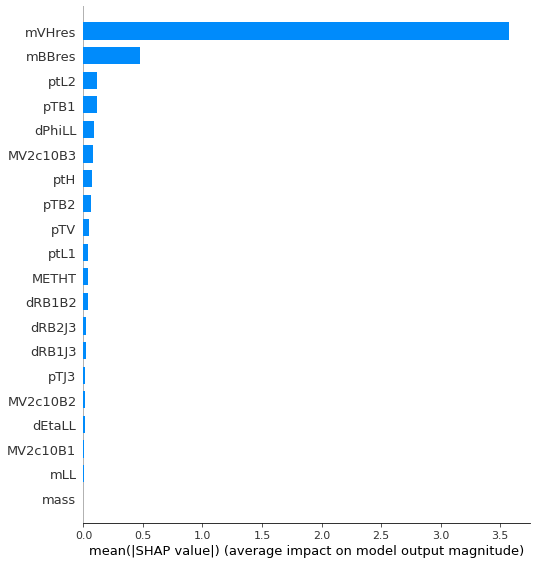

In [9]:
shap.initjs()
X_imputed_df = pd.DataFrame(inputsignal, columns = thissignal.drop(columns=["weight"]).columns)
a = shap.summary_plot(shap_values2, X_imputed_df, plot_type="bar", show=False)
plt.savefig('scratch.pdf', bbox_inches='tight')

In [24]:
shap.force_plot(explainer2.expected_value, shap_values2[1], X_imputed_df.iloc[1,:], link="logit")

In [25]:
shap.force_plot(explainer2.expected_value, shap_values2, X_imputed_df)